In [1]:
# Base imports
import time
import datetime
import pytz
# IO Imports
import os
import json
# Datawork Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def retrieve_data(data_path = "../data1/", start_idx=0, stop_idx=60):
    # list to store files
    f_store = []
    results = {}
    columns = []
    
    # Iterate directory
    for file_name in os.listdir(data_path):
        # check if current file_path is a file
        if os.path.isfile(os.path.join(data_path, file_name)):
            # add filename to list
            f_store.append(file_name)

    flag = True
    for file_name in f_store:
        data = {}
        tmp_dt = ''
        # Open the JSON file
        with open(data_path + file_name) as file:
            data = json.load(file)
        for i in range(start_idx, stop_idx+1):
            try:
                if data:
                    if i == start_idx:
                        tmp_dt = data[str(i)]['timestamp']
                    
                    if file_name == f_store[0]:
                        columns.append(data[str(i)]['name'])
                    if flag:
                        if i == start_idx:
                            results['timestamp'] = [tmp_dt]
                        results[columns[i]] = [data[str(i)]['value']]
                    else:
                        if i == start_idx:
                            results['timestamp'].append(tmp_dt)
                        results[columns[i]].append(data[str(i)]['value'])
            except KeyError:
                print(file_name)
                print(i)
                pass
        flag = False
    #print(results)
    return results

In [3]:
def dynamic_plot(df, fields, names, units):
    
    # Create a figure with subplots
    num_fields = len(fields)
    fig, axes = plt.subplots(num_fields, 1, figsize=(15, 5 * num_fields))
    fig.subplots_adjust(hspace=0.5)  # Adjust space between subplots

    # Create timezone for x-axis formatting
    est = pytz.timezone('US/Eastern')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)

    # Iterate through the fields and create individual plots
    for idx in range(num_fields):
        temp = df[[fields[idx]]]
        axes[idx].plot(df['EST'], temp, label=names[idx])
        
        # Set x-axis formatter and labels
        axes[idx].xaxis.set_major_formatter(myFmt)
        axes[idx].set_xlabel('Time (HH:MM)')
        axes[idx].set_ylabel(f'{names[idx]} ({units[idx]})')  # Use unit from the units list
        axes[idx].set_title(f'{names[idx]} Over Time')
        #fig.autofmt_xdate()  # Rotate date labels for better readability

    # Add a legend to each subplot
    for ax in axes:
        ax.legend()

    plt.show()

In [4]:
def all_plot(df, fields, names):
    # Initialize MinMaxScaler for normalization
    scaler = MinMaxScaler()
    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 10))
    # Create X Axis
    est = pytz.timezone('EST')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()  # Rotate date labels for better readability

    # Add labels and title
    ax.set_xlabel('Time (HH:MM)')
    ax.set_ylabel('Normalized Value')
    ax.set_title('Normalized Variables Over Time')

    data_fields = []
    
    for idx in range(len(fields)):
        temp = scaler.fit_transform(df[[fields[idx]]])
        data_fields.append(temp)
        ax.plot(df['EST'], temp, label=names[idx])

    # Add a legend
    ax.legend()

    #return data_fields

In [5]:
def plot_removal(df, fields, names):
    
    # Initialize MinMaxScaler for normalization
    scaler = MinMaxScaler()
    fields.append('timestamp')
    df_temp = df[fields].copy(deep=True)
    df_temp['tempDIFF'] = df_temp[fields[1]]-df_temp[fields[0]]
    df_temp = df_temp[df_temp['tempDIFF']>0]

    tempDIFF = scaler.fit_transform(df_temp[['tempDIFF']])
    field0 = scaler.fit_transform(df_temp[[fields[0]]])
    field1 = scaler.fit_transform(df_temp[[fields[1]]])    
    
    #tempDIFF = df_temp[['tempDIFF']]
    #field0 = df_temp[[fields[0]]]
    #field1 = df_temp[[fields[1]]]
    
    time_temp = df_temp[['timestamp']]
    
    # Create a figure
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    # Create X Axis
    est = pytz.timezone('EST')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)
    axs[0].xaxis.set_major_formatter(myFmt)
    axs[1].xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()  # Rotate date labels for better readability
    
    # Add labels and title
    axs[0].set_xlabel('Time (HH:MM)')
    #ax.set_ylabel('Normalized Value')
    #x.set_title('Normalized Variables Over Time')
    
    axs[0].plot(time_temp,tempDIFF, label = 'Differential')    
    axs[0].plot(time_temp,field0, label = names[0])    
    axs[0].plot(time_temp,field1, label = names[1])

    axs[1].plot(time_temp,df_temp[['tempDIFF']], label = 'Differential')

    # Add a legend
    axs[0].legend()
    axs[1].legend()

In [6]:
res=retrieve_data(data_path = "../data1/")
df = pd.DataFrame.from_dict(res)
df['timestamp']= pd.to_datetime(df['timestamp'],  format='%d.%m.%Y %H:%M:%S,%f')
df['EST'] = (df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern'))

In [7]:
fields = [
    'GECO/MP_Pump_Pressure_Current_bar_R',
    'GECO/MPTX_DI_Water_Temperature_C_R',
    'GECO/MPXMB_Pump_OutputCurrent_dA_I',
    'GECO/MPXMB_Pump_OutputPower_W_I',
    'GECO/MPTX_DI_Mortar_Temperature_C_R',
#    'GECO/MPTX_DI_Air_Temperature_C_R' 
]

names = [
    'Pump Pressure',
    'Water Temp',
    'Pump Current',
    'Pump Power',
    'Mortar Tempurature',
#    'Ambient Temp'
]

units = [
    'BAR',
    'C',
    'dA',
    'W',
    'C'
#    'C'
]

In [8]:
start = 800
stop = 4800

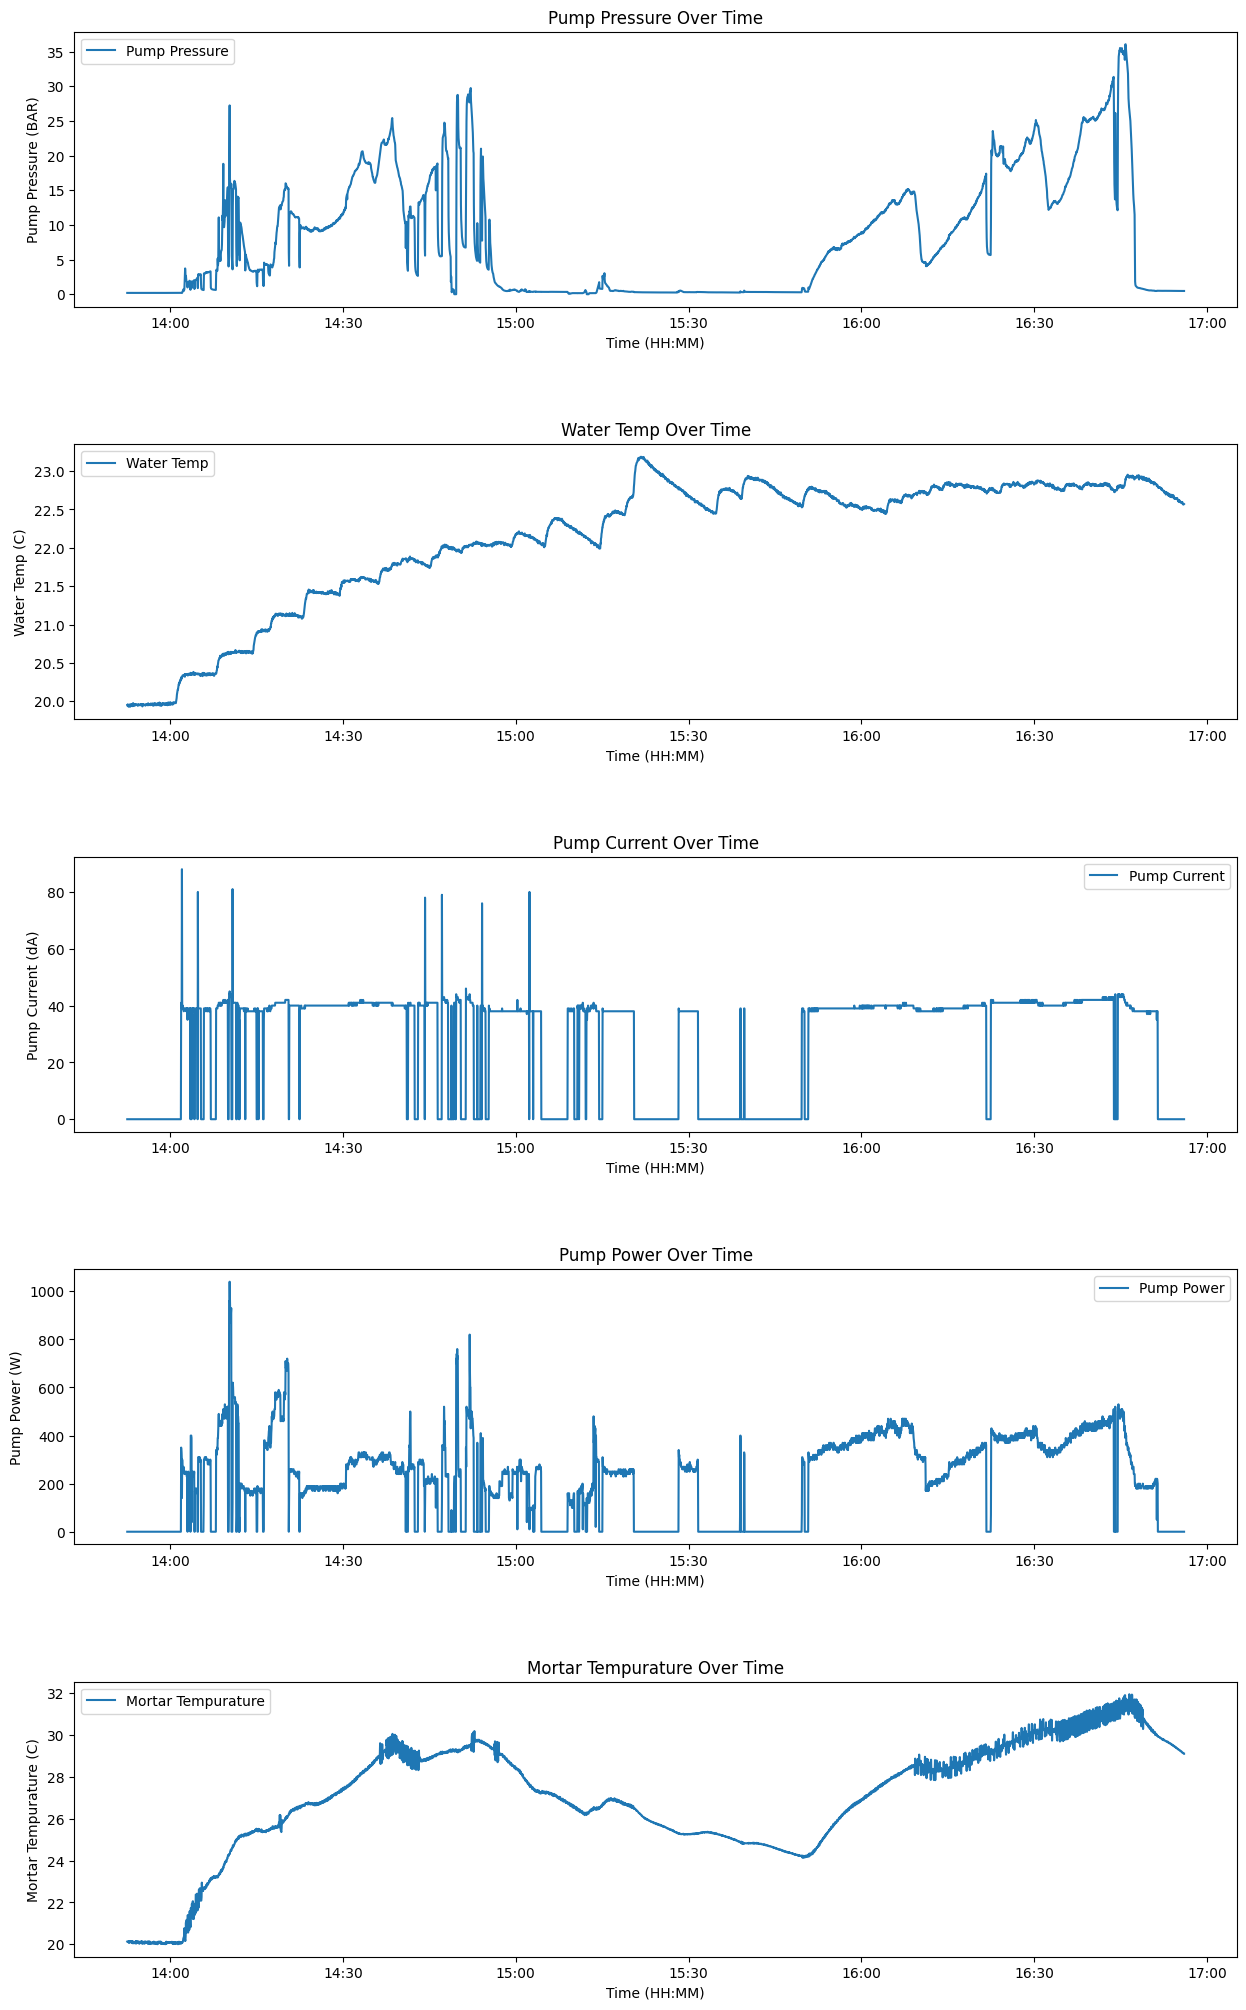

In [9]:
dynamic_plot(df[start:stop], fields, names, units)

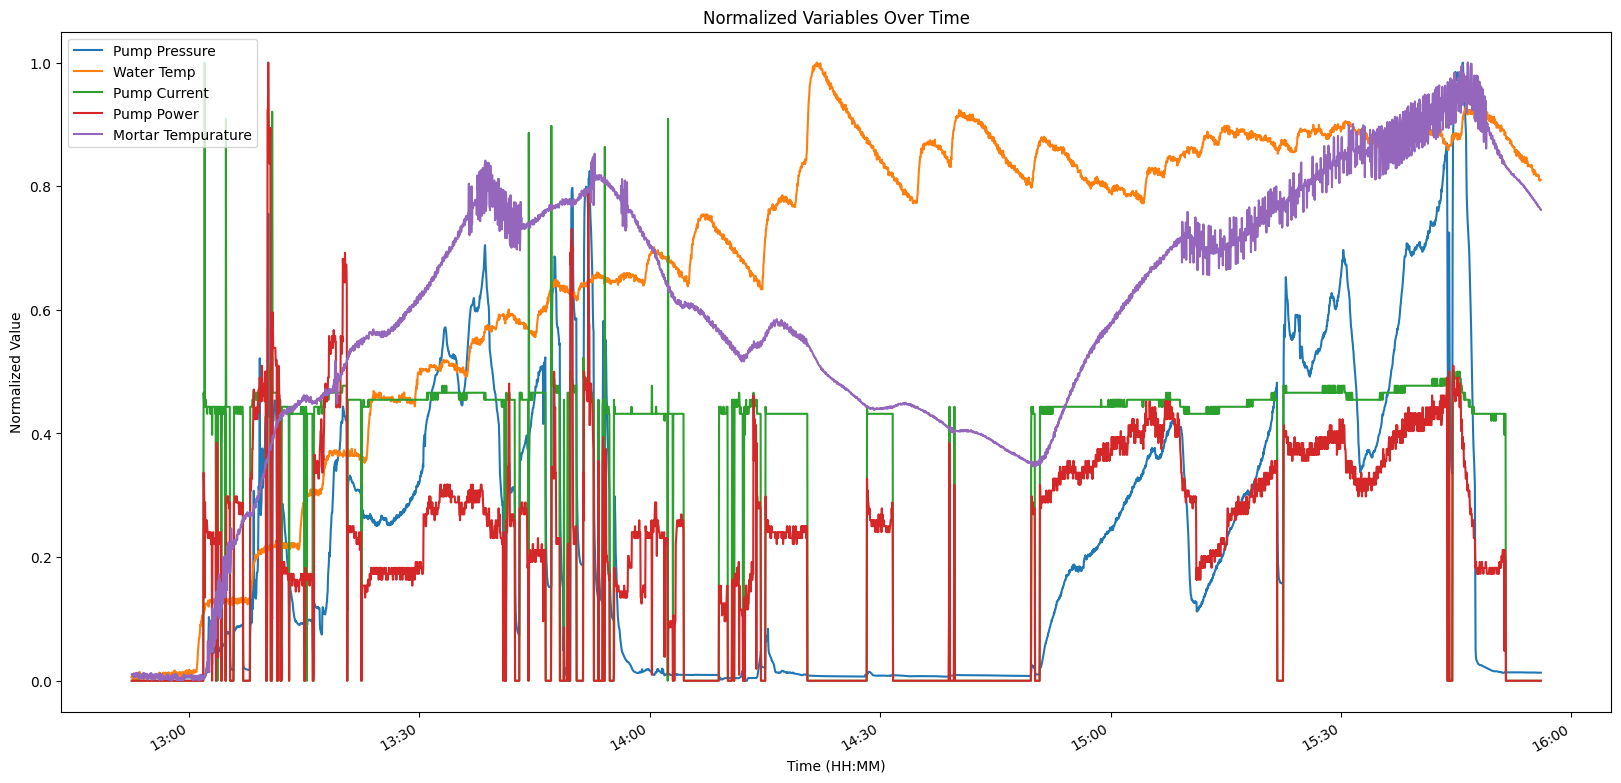

In [10]:
all_plot(df[start:stop], fields, names)

In [11]:
fields = [
#    'GECO/MP_Pump_Pressure_Current_bar_R',
    'GECO/MPTX_DI_Water_Temperature_C_R',
#    'GECO/MPXMB_Pump_OutputCurrent_dA_I',
#    'GECO/MPXMB_Pump_OutputPower_W_I',
    'GECO/MPTX_DI_Mortar_Temperature_C_R',
    'GECO/MPTX_DI_Air_Temperature_C_R' 
]

names = [
#    'Pump Pressure',
    'Water Temp',
#    'Pump Current',
#    'Pump Power',
    'Mortar Tempurature',
    'Ambient Temp'
]

units = [
#    'BAR',
    'C',
#    'dA',
#    'W',
    'C'
    'C'
]

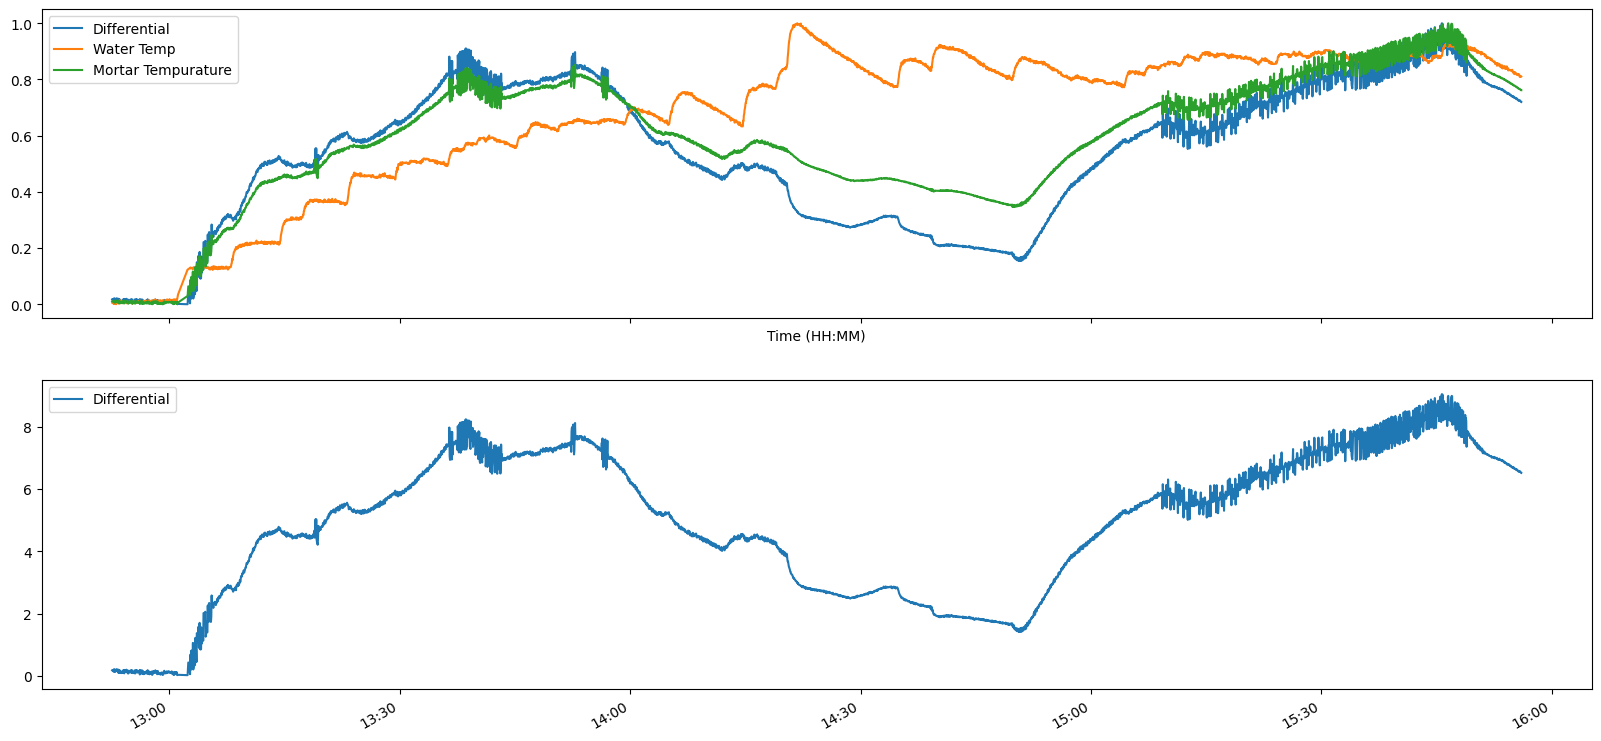

In [12]:
plot_removal(df[start:stop], fields, names)